<a href="https://colab.research.google.com/github/AnkurMali/IST597_Spring_2022/blob/main/MLP_Fmnist_Saver_optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt


np.random.seed(1234)
tf.random.set_seed(1234)

In [2]:
tf.config.list_physical_devices('GPU')

[]

4431872/4422102 [==============================] - 0s 0us/step


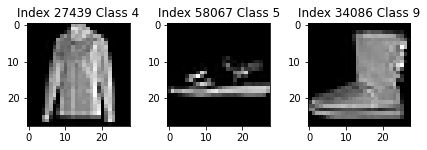

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data() # Load MNIST or FMNIST
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)


# Display randomly selected data
indices = list(np.random.randint(X_train.shape[0],size=3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(X_train[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], y_train[indices[i]]))
    plt.tight_layout()

# Important
* Always have a validation set, the procedure to create validation or dev set is by performing random sample without replacement on train set and then only using that fraction as dev set. 
* Simple approach is to set some K samples, you can extract them from start, mid or end.
* Imagine validation set that partially approximates test set distribution and we assume our model would produce identical results when we test it on test set.
* Always optimize your hyperparameters by looking at performance on validation set and not test set.
* Do not touch test set, we have this to test how our model would work on unseen data.

In [4]:
# Split train dataset into train and validation
X_val = X_train[50000:60000]
X_train = X_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example is", str(X_train.shape[1]), "by", str(X_train.shape[2]))

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example is", str(X_val.shape[1]), "by", str(X_val.shape[2]))

X_train = X_train.reshape(50000, 28*28)
X_val = X_val.reshape(10000, 28*28)
X_test = X_test.reshape(10000, 28*28)

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example has", str(X_train.shape[1]), "features")

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example has", str(X_val.shape[1]), "features")

# Split dataset into batches
#train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
#test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)

size of training set is 50000 samples
every train example is 28 by 28
size of validation set is 10000 samples
every validation example is 28 by 28
size of training set is 50000 samples
every train example has 784 features
size of validation set is 10000 samples
every validation example has 784 features


# Points to remember
* If using any type of neural network, normalize your input between 0-1.
* One can use various procedures to achieve this, divide by largest value (for images we use 255), subtract mean from data and then normalize, one can even augment them and use other steps for normalization.
* Normalization is important step, one could observe significant boost in performance just by having better normalization scheme.
* For targets we always use one-hot encodings.

In [5]:
#Normalize Data

X_train = X_train/255
X_val = X_val/255
X_test = X_test/255
# X_train[0]
np.max(X_train)

1.0

In [6]:
size_input = X_train.shape[1]
size_hidden1 = 128
size_hidden2 = 128
size_hidden3 = 128
size_output = 10

number_of_train_examples = X_train.shape[0]
number_of_test_examples = X_test.shape[0]

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) # Other function is tf.one_hot(y_train,depth=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
print(tf.shape(y_val))

tf.Tensor([10000    10], shape=(2,), dtype=int32)


# Importance of weight initialization

* One reason backprop based models can perform bettter lies with the weight initialization method, one important point one should remember is that, if yur weights are initialized to be too high or low, backprop would struggle.
* Hence one should always carefully initialize weights of your model, below i have shown approach with random_normal, one can use random_uniform, truncated version of both, Xavier init and orthogonal. 
* You will find modern day NNs have achieved stable and better performance by simply switching to better init and majority of cases Xavier or Orthogonal works best.
* Always initialize your bias using zero or some small constant (ideally 0.01 or less works better). We use bias to shift the activation and in some cases it can stabalize learning, but having large bias can cause negative results.

# Loss function

* We will always cross-entropy loss for classification.

* tf softmax,
loss= tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf)), this function is simply saying that it will calculate softmax for you, simply provide logits to it. 

* In other output of your forward pass directly goes this function. Now this operator will calculate or apply softmax over prediction or logits and calculate cross-entropy between prediction and target. I am using reduce_mean since we apply this over batches.
* Second is using keras
Method 1 :- This function requires logits, hence same as above you will pass logits or output variable to this function. Now remember you need from_logits = True, for this to work.
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
loss_x = cce(y_true_tf, y_pred_tf) 

* Method 2:- In this we will apply softmax to output function and then pass to CCE loss.
So the approach is 
output = tf.nn.softmax(output)
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
loss_x = cce(y_true_tf, y_pred_tf) 

In [7]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    self.g1 = tf.Variable(tf.random.normal([1, self.size_hidden1], stddev = 0.1))    
    self.beta1= tf.Variable(tf.random.normal([1, self.size_hidden1], stddev = 0.1))    
    self.g2 = tf.Variable(tf.random.normal([1, self.size_hidden2], stddev = 0.1))    
    self.beta2= tf.Variable(tf.random.normal([1, self.size_hidden2], stddev = 0.1))    
    self.g3 = tf.Variable(tf.random.normal([1, self.size_hidden3], stddev = 0.1))    
    self.beta3= tf.Variable(tf.random.normal([1, self.size_hidden3], stddev = 0.1))    
   
    self.m1 = tf.Variable(tf.random.normal([1, self.size_hidden1], stddev = 0.1))    
    self.std1= tf.Variable(tf.random.normal([1, self.size_hidden1], stddev = 0.1))    
    self.m2 = tf.Variable(tf.random.normal([1, self.size_hidden2], stddev = 0.1))    
    self.std2= tf.Variable(tf.random.normal([1, self.size_hidden2], stddev = 0.1))    
    self.m3 = tf.Variable(tf.random.normal([1, self.size_hidden3], stddev = 0.1))    
    self.std3= tf.Variable(tf.random.normal([1, self.size_hidden3], stddev = 0.1))   
    self.e=0.1
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4,self.g1,self.beta1,self.g2,self.beta2,self.g3,self.beta3]
  
 def forward(self, X,train=True):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X,train)
    else:
      self.y = self.compute_output(X,train)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

 def backward(self, X_train, y_train, opti):
    """
    backward pass
    """
    optimizer = opti
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
           
 def compute_output(self, X,train=True):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X

    if(train):
    
      h3 = self.BatchNormTrain(X_tf)
      # Compute output
      output = tf.matmul(h3, self.W4) + self.b4
      return (output)

    else:
      h3 = self.BatchNormTest(X_tf)
      # Compute output
      output = tf.matmul(h3, self.W4) + self.b4
      return (output)

      
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable

 def BatchNormTrain(self,X_tf):

    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    h1 = (self.g1*(h1-np.mean(h1, 0))/(np.std(h1, 0) + tf.math.sqrt(self.e)))+self.beta1
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    h2 = (self.g2*(h2-np.mean(h2, 0))/(np.std(h2, 0) + tf.math.sqrt(self.e)))+self.beta2
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)
    h3 = (self.g3*(h3-np.mean(h3, 0))/(np.std(h3, 0) + tf.math.sqrt(self.e)))+self.beta3
    
    return h3
 def BatchNormTest(self,X_tf):
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    h1 = (self.g1*(h1-self.m1)/self.std1)+self.beta1
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    h2 = (self.g2*(h2-self.m2)/self.std2)+self.beta2
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)
    h3 = (self.g3*(h3-self.m3)/self.std3)+self.beta3
 
    return h3


 def initMeanAndVarianceForEntireTestSet(self, X):
    X_tf = tf.cast(X, dtype=tf.float32)

    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    self.m1=np.mean(h1, 0)
    self.std1=np.std(h1, 0)+ tf.math.sqrt(self.e)
    h1 = (self.g1*(h1-self.m1)/self.std1)+self.beta1

    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    self.m2=np.mean(h2, 0)
    self.std2=np.std(h2, 0)+ tf.math.sqrt(self.e)
    h2= (self.g2*(h2-self.m2)/self.std2)+self.beta2
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)
    self.m3=np.mean(h3, 0)
    self.std3=np.std(h3, 0)+ tf.math.sqrt(self.e)





#  def stderr(self,y_pred):
#     """
#      Calculate standard error
#      """
#     y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
#     std_dev = np.std(y_pred_tf) #Calculates standard deviation
#     std_err = std_dev/sqrt(len(y_pred_tf))
#     return std_err 


#  def var(self,y_pred):
#     """
#      Calculate variance 
#      """
#     y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
#     std_dev = np.std(y_pred_tf) #Calculates standard deviation
#     variance = (std_dev**2) # calculate variance
#     return variance 



In [8]:
seed = [99998,321,878,7,56,876,6666,7777,3452,5]
NUM_EPOCHS = 40
opti = tf.keras.optimizers.SGD(learning_rate = 0.1)




for x in seed:
  print('For Seed',x,':')

  #Default mode
  mlp_on_default = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')
  #hidden2 = MLP(size_hidden2, size_hidden2, size_output, device='gpu')
  time_start = time.time()

  for epoch in range(NUM_EPOCHS):
    loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
    lt = 0
    acc = 0
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(x)).batch(64)
    accuracies = []
    for inputs, outputs in train_ds:
      preds = mlp_on_default.forward(inputs)
      loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
      acc = loss_total_gpu + mlp_on_default.loss(preds, outputs)
      lt = lt + mlp_on_default.loss(preds, outputs)
      mlp_on_default.backward(inputs, outputs,opti)
    mlp_on_default.initMeanAndVarianceForEntireTestSet(X_train)
    Accpred = mlp_on_default.forward(X_train,False)
    cat_acc = tf.metrics.CategoricalAccuracy()
    accuracies.append(cat_acc(Accpred, y_train))
    ValAccuracies = []
    Accpred = mlp_on_default.forward(X_val,False)
    cat_acc = tf.metrics.CategoricalAccuracy()
    ValAccuracies.append(cat_acc(Accpred, y_val))
    if((epoch+1)%2 == 0):
      print('Number of Epoch = {} - Average Loss:= {} Validation Accuracy:= {} Training Accuracy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0],np.mean(ValAccuracies)*100,np.mean(accuracies)*100))

  time_taken = time.time() - time_start
  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

  #inference
  test_loss_total = tf.Variable(0, dtype=tf.float32)
  #test_loss_total = 0.0
  test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(25, seed=epoch*(x)).batch(64)
  cat_acc = tf.metrics.CategoricalAccuracy()
  accuracies = []
  mlp_on_default.initMeanAndVarianceForEntireTestSet(X_train)
  for inputs, outputs in test_ds:
    preds = mlp_on_default.forward(inputs,False)
    test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
    cat_acc = tf.metrics.CategoricalAccuracy()  
    accuracies.append(cat_acc(preds, outputs))


  print('Inference Loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))
  print('Inference Accuracy: {:.4f}'.format(np.mean(accuracies)*100))

For Seed 99998 :
Number of Epoch = 2 - Average Loss:= 0.010805626220703125 Validation Accuracy:= 61.229997873306274 Training Accuracy:= 61.60399913787842
Number of Epoch = 4 - Average Loss:= 0.005471182250976562 Validation Accuracy:= 75.34000277519226 Training Accuracy:= 75.71600079536438
Number of Epoch = 6 - Average Loss:= 0.004427751770019531 Validation Accuracy:= 80.8899998664856 Training Accuracy:= 81.86799883842468
Number of Epoch = 8 - Average Loss:= 0.0037790463256835937 Validation Accuracy:= 82.9800009727478 Training Accuracy:= 83.99800062179565
Number of Epoch = 10 - Average Loss:= 0.0034316485595703126 Validation Accuracy:= 84.36999917030334 Training Accuracy:= 85.29000282287598
Number of Epoch = 12 - Average Loss:= 0.003190088806152344 Validation Accuracy:= 85.4200005531311 Training Accuracy:= 86.33000254631042
Number of Epoch = 14 - Average Loss:= 0.0030170492553710936 Validation Accuracy:= 85.6000006198883 Training Accuracy:= 86.84599995613098
Number of Epoch = 16 - Avera

KeyboardInterrupt: ignored


Train Accuracy: 0.8292
Number of Epoch = 1 - Average Cross Entropy:= 0.0070905438232421875 

Validation Accuracy: 0.8208

Train Accuracy: 0.8545
Number of Epoch = 2 - Average Cross Entropy:= 0.0035109307861328127 

Validation Accuracy: 0.8450

Train Accuracy: 0.8680
Number of Epoch = 3 - Average Cross Entropy:= 0.0031131005859375 

Validation Accuracy: 0.8561

Train Accuracy: 0.8771
Number of Epoch = 4 - Average Cross Entropy:= 0.0028826300048828126 

Validation Accuracy: 0.8634

Train Accuracy: 0.8849
Number of Epoch = 5 - Average Cross Entropy:= 0.0026978872680664063 

Validation Accuracy: 0.8685

Train Accuracy: 0.8889
Number of Epoch = 6 - Average Cross Entropy:= 0.0025520314025878907 

Validation Accuracy: 0.8685

Train Accuracy: 0.8960
Number of Epoch = 7 - Average Cross Entropy:= 0.0024296630859375 

Validation Accuracy: 0.8734

Train Accuracy: 0.8972
Number of Epoch = 8 - Average Cross Entropy:= 0.002314106750488281 

Validation Accuracy: 0.8728

Train Accuracy: 0.9043
Number 

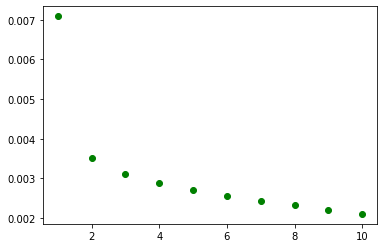

In [ ]:
# Set number of epochs
NUM_EPOCHS = 10

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start = time.time()
opti = tf.keras.optimizers.SGD(learning_rate = 0.1)
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(1234)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs, opti)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs



Train Accuracy: 0.8708
Number of Epoch = 1 - Average Cross Entropy:= 0.004519539489746094 

Validation Accuracy: 0.8588

Train Accuracy: 0.8870
Number of Epoch = 2 - Average Cross Entropy:= 0.0028923043823242188 

Validation Accuracy: 0.8687

Train Accuracy: 0.8951
Number of Epoch = 3 - Average Cross Entropy:= 0.0025675372314453125 

Validation Accuracy: 0.8733

Train Accuracy: 0.8996
Number of Epoch = 4 - Average Cross Entropy:= 0.0023671160888671873 

Validation Accuracy: 0.8758

Train Accuracy: 0.9065
Number of Epoch = 5 - Average Cross Entropy:= 0.0022008470153808595 

Validation Accuracy: 0.8756

Train Accuracy: 0.9089
Number of Epoch = 6 - Average Cross Entropy:= 0.002058603668212891 

Validation Accuracy: 0.8753

Train Accuracy: 0.9155
Number of Epoch = 7 - Average Cross Entropy:= 0.0019298921203613282 

Validation Accuracy: 0.8775

Train Accuracy: 0.9155
Number of Epoch = 8 - Average Cross Entropy:= 0.0018463410949707032 

Validation Accuracy: 0.8767

Train Accuracy: 0.9152
Nu

NameError: ignored

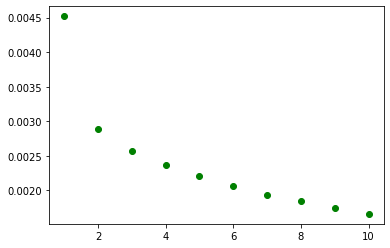

In [ ]:
# Set number of epochs
NUM_EPOCHS = 10

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start = time.time()
opti = tf.keras.optimizers.SGD(learning_rate = 0.1, momentum=0.9)
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(1234)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs, opti)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')


        
time_taken = time.time() - time_start
    
# Validate model

    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

#RMSProp

* Maintain a moving average of the square of gradients
* Divide the gradient by the root of this moving average


Train Accuracy: 0.8524
Number of Epoch = 1 - Average Cross Entropy:= 0.004470570068359375 

Validation Accuracy: 0.8475

Train Accuracy: 0.8586
Number of Epoch = 2 - Average Cross Entropy:= 0.0030924380493164063 

Validation Accuracy: 0.8457

Train Accuracy: 0.8832
Number of Epoch = 3 - Average Cross Entropy:= 0.002732566833496094 

Validation Accuracy: 0.8716

Train Accuracy: 0.8878
Number of Epoch = 4 - Average Cross Entropy:= 0.0024964035034179687 

Validation Accuracy: 0.8725

Train Accuracy: 0.8959
Number of Epoch = 5 - Average Cross Entropy:= 0.002327974395751953 

Validation Accuracy: 0.8769

Train Accuracy: 0.8975
Number of Epoch = 6 - Average Cross Entropy:= 0.002187594757080078 

Validation Accuracy: 0.8749

Train Accuracy: 0.9050
Number of Epoch = 7 - Average Cross Entropy:= 0.0020711753845214843 

Validation Accuracy: 0.8805

Train Accuracy: 0.9016
Number of Epoch = 8 - Average Cross Entropy:= 0.0019677088928222656 

Validation Accuracy: 0.8729

Train Accuracy: 0.9134
Numb

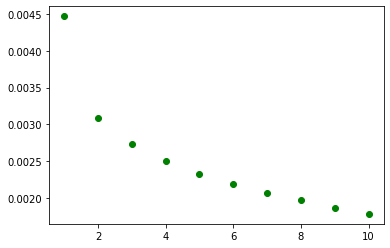

In [ ]:
# Set number of epochs
NUM_EPOCHS = 10

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start = time.time()
opti = tf.keras.optimizers.RMSprop(learning_rate = 1e-3)
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(1234)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs, opti)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


#Adam
* Combine RMSprop with momentum
* Default optimizer in many applications
* In some scenarios leads to poor performance such as Continual learning, lifelong learning, metalearning


Train Accuracy: 0.8039
Number of Epoch = 1 - Average Cross Entropy:= 0.007583687744140625 

Validation Accuracy: 0.7970

Train Accuracy: 0.8350
Number of Epoch = 2 - Average Cross Entropy:= 0.004100390014648438 

Validation Accuracy: 0.8247

Train Accuracy: 0.8481
Number of Epoch = 3 - Average Cross Entropy:= 0.0036029278564453124 

Validation Accuracy: 0.8397

Train Accuracy: 0.8569
Number of Epoch = 4 - Average Cross Entropy:= 0.003350390625 

Validation Accuracy: 0.8485

Train Accuracy: 0.8631
Number of Epoch = 5 - Average Cross Entropy:= 0.0031754852294921874 

Validation Accuracy: 0.8533

Train Accuracy: 0.8676
Number of Epoch = 6 - Average Cross Entropy:= 0.003048553161621094 

Validation Accuracy: 0.8583

Train Accuracy: 0.8716
Number of Epoch = 7 - Average Cross Entropy:= 0.0029451785278320312 

Validation Accuracy: 0.8604

Train Accuracy: 0.8746
Number of Epoch = 8 - Average Cross Entropy:= 0.0028560934448242188 

Validation Accuracy: 0.8632

Train Accuracy: 0.8778
Number of 

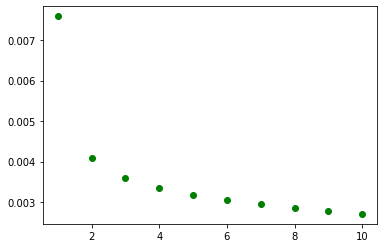

In [ ]:
# Set number of epochs
NUM_EPOCHS = 10

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start = time.time()
opti = tf.keras.optimizers.Adam(learning_rate = 1e-4)
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(1234)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs, opti)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


#Nadam Optimizer
* Combine Adam with Nesterov momentum
* In somecases (image segmentation, object detection) it performs stably and leads to faster convergence 


Train Accuracy: 0.8079
Number of Epoch = 1 - Average Cross Entropy:= 0.007469556884765625 

Validation Accuracy: 0.7991

Train Accuracy: 0.8344
Number of Epoch = 2 - Average Cross Entropy:= 0.004099525146484375 

Validation Accuracy: 0.8271

Train Accuracy: 0.8484
Number of Epoch = 3 - Average Cross Entropy:= 0.0036003802490234375 

Validation Accuracy: 0.8427

Train Accuracy: 0.8568
Number of Epoch = 4 - Average Cross Entropy:= 0.003330947265625 

Validation Accuracy: 0.8523

Train Accuracy: 0.8645
Number of Epoch = 5 - Average Cross Entropy:= 0.0031479156494140623 

Validation Accuracy: 0.8582

Train Accuracy: 0.8686
Number of Epoch = 6 - Average Cross Entropy:= 0.003007879943847656 

Validation Accuracy: 0.8600

Train Accuracy: 0.8734
Number of Epoch = 7 - Average Cross Entropy:= 0.002898348388671875 

Validation Accuracy: 0.8628

Train Accuracy: 0.8766
Number of Epoch = 8 - Average Cross Entropy:= 0.0028031634521484376 

Validation Accuracy: 0.8660

Train Accuracy: 0.8801
Number o

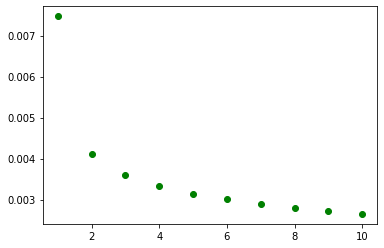

In [ ]:
# Set number of epochs
NUM_EPOCHS = 10

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start = time.time()
opti = tf.keras.optimizers.Nadam(learning_rate = 1e-4)
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(1234)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs, opti)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

# Saving your model weights or parameters
* It is always advisable to save your model checkpoints every k epochs. Look at Saver object in tensorflow/keras.
* Visualize your model performance using tensorboard.

# Steps to save model weights using pickle
* Save your model(trainable variables), in our case self.variables into a pickle file.
* Load saved file
* Redefine model
* Load weights
* Re-train or test your model


In [ ]:
#
import pickle
variables_old = mlp_on_cpu.variables
with open('weights.pickle', 'wb') as handle:
    pickle.dump(variables_old, handle)

In [ ]:
with open('weights.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [ ]:
# Define class to build mlp model
class MLP_check(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
  
 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

 def backward(self, X_train, y_train, opti):
    """
    backward pass
    """
    optimizer = opti
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
           
 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)



In [ ]:
MLP_after_check = MLP_check(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')
W = MLP_after_check.variables[0]
W.assign(b[0])
W1 = MLP_after_check.variables[1]
W1.assign(b[1])
W2 = MLP_after_check.variables[2]
W2.assign(b[2])
W3 = MLP_after_check.variables[3]
W3.assign(b[3])
B = MLP_after_check.variables[4]
B.assign(b[4])
B1 = MLP_after_check.variables[5]
B1.assign(b[5])
B2 = MLP_after_check.variables[6]
B2.assign(b[6])
B3 = MLP_after_check.variables[7]
B3.assign(b[7])


<tf.Variable 'UnreadVariable' shape=(1, 10) dtype=float32, numpy=
array([[ 0.31285602, -0.56231725,  0.6267492 ,  0.08308472,  0.28097275,
        -0.26073027,  0.27095762, -0.27032936,  0.09554584, -0.5767893 ]],
      dtype=float32)>

In [ ]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  #test_loss_total = test_loss_total + MLP_after_check.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = MLP_after_check.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

KeyboardInterrupt: ignored

In [ ]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.3250

Test Accuracy: 0.87
